# Question

Is there an easy way to merge circuits, so take 3 pregenerated circuits and merge them to one big one?

In [396]:
import numpy as np
import matplotlib.pyplot as plt
import pymatching
import stim

circ_path = "circuits/"
plot_path = "plots/"

# Plan to generalize for higher distance codes 


Dont fix stuff that is not broken!


# Questions 

for general state I should add the second set of stabilizers to the general qubit? 
 -> just a question if I should enable general encoding but there should not be any need for it ...


is this already circuit-level noise? (errors after each gate?)
+ code-capacity model  (just physical dataqubits fail?)
+ phenomenological noise model (stabilizer can fail with fixed prob?)

What should i call this noise model?


# Not yet implemented  (needed?)

idle time errors

layout for arbitrary code size 


In [397]:
def coordinates_to_indices(coords, offset):
    temp = [np.argwhere(np.array(coord)[:] == 1).ravel() + offset for coord in coords]
    temp2 = [x for x in temp if x.size != 0]  # getting rid of empty arrays (otherwise they misbehave at later points of time)
    return temp2 

def create_stabilizers(d,qubit_offset=0):
    # stolen but adapted from the workshop

    #X stabilizers
    X_stabilizers=np.zeros(((d**2-1)//2,d**2),dtype=int) # [index_stabilizer, flattend stabilizer]
    counter = 0 # total number of stabilizer generated until now
    # upper edge
    for i in range((d-1)//2): #iter stabilizer per row
        X_stabilizers[counter,i*2+1] = 1
        X_stabilizers[counter,i*2+2] = 1
        counter += 1 
    # bulk
    for i in range(d-1): #iterating over rows 
        for j in range((d-1)//2): #iter stabilizer per row
            shift = i%2 # each second row has an offset
            # top two stabilizers
            X_stabilizers[counter,(shift + j*2) + (i*d)] = 1
            X_stabilizers[counter,(shift + j*2) + (i*d +1)] = 1
            # lower two stabilizers
            X_stabilizers[counter, (shift + j*2) + ((i+1)*d) ] = 1
            X_stabilizers[counter, (shift + j*2) + ((i+1)*d +1)] = 1
            counter += 1
    # lower edge
    for i in range((d-1)//2):
        shift = (d-1)*d
        X_stabilizers[counter,shift+i*2] = 1
        X_stabilizers[counter,shift+1+2*i] = 1
        counter += 1

    #Z stabilizers
    Z_stabilizers = np.zeros(((d**2-1)//2,d**2),dtype=int)
    counter = 0
    step = d+1
    # left edge
    for i in range((d-1)//2):
        Z_stabilizers[counter,(2*i)*d] = 1
        Z_stabilizers[counter,(2*i+1)*d] = 1
        counter += step
    counter = 1
    # bulk
    for i in range(d-1):
        shift = (i+1)%2
        for j in range((d-1)//2):
            Z_stabilizers[counter,shift + 2*j + i*d] = 1
            Z_stabilizers[counter,shift + 2*j + i*d + 1] = 1
            Z_stabilizers[counter,shift + 2*j + (i+1)*d] = 1
            Z_stabilizers[counter,shift + 2*j + (i+1)*d + 1] = 1
            counter += 1
        if i%2:
            counter += 2
    offset = (2*d)-1
    counter = step-1
    # right edge
    for i in range((d-1)//2):
        Z_stabilizers[counter,offset + 2*i*d] = 1
        Z_stabilizers[counter,offset + (1+2*i)*d] = 1
        counter += step
    
    
    # change to indices from coordinates:
    Z_stabilizers = coordinates_to_indices(Z_stabilizers,qubit_offset)
    X_stabilizers = coordinates_to_indices(X_stabilizers,qubit_offset)

    return Z_stabilizers, X_stabilizers


In [398]:
def initialize_qubit(
        circuit,
        distance,
        state="0",
        ):
    
    if state == "0":
        gen_x_stabilizer = True
        gen_z_stabilizer = False 
    elif state == "+" or state == "p":
        gen_x_stabilizer = False 
        gen_z_stabilizer = True 
    else: 
        # general state
        gen_x_stabilizer = True
        gen_z_stabilizer = True 

    # log_qubit saves all the relevant info about that log qubit
    log_qubit = {}
    log_qubit["distance"] = distance
    log_qubit["Z_stabilizers"], log_qubit["X_stabilizers"] = create_stabilizers(distance, qubit_offset=circuit.num_qubits)
    # list in which I store the indices of measurements taken on this qubit
    log_qubit["Z_stab_measure"] = []  # list of list [[[SZ_1],[SZ_2],...], [[SZ_1],...], ... ] list of each set of stabilizer measurements performed on the qubit!
    log_qubit["X_stab_measure"] = []  # is used to construct detectors 
    log_qubit["data_measure"] = []  #TODO maybe not as important

    # assign indices and to qubits and initalize the relevant phy. qubits 
    log_qubit["data"] = np.arange(circuit.num_qubits, circuit.num_qubits + distance**2, dtype=int) 
    circuit.append("R", log_qubit["data"])  

    if gen_z_stabilizer:
        # 1 measure-qubit for each stabilizer
        log_qubit["Z_measure"] = np.arange(circuit.num_qubits, circuit.num_qubits + len(log_qubit["Z_stabilizers"]),dtype=int)
        circuit.append("R", log_qubit["Z_measure"]) 
    
    if gen_x_stabilizer:
        log_qubit["X_measure"] = np.arange(circuit.num_qubits, circuit.num_qubits + len(log_qubit["X_stabilizers"]),dtype=int)
        circuit.append("R", log_qubit["X_measure"]) 
    

    # apply transformation to data qubits to start in correct state
    if state =="+" or state == "p":
        circuit.append("H", log_qubit["data"])
    
    # encode data qubits (add stabilizers) 
    if gen_z_stabilizer:
        circuit, log_qubit = add_z_stabilizer(circuit,log_qubit) 

    if gen_x_stabilizer:
        circuit, log_qubit = add_x_stabilizer(circuit,log_qubit) 

    return circuit, log_qubit

In [399]:
def add_z_stabilizer(circuit, log_qubit):
    """
    Adds a Z-stabiliser measurement using auxilliary qubits to the given logical qubit.
    """
    # entanle data qubits with aux qubits
    for i, stabilizer in enumerate(log_qubit["Z_stabilizers"]):
        for data_target in stabilizer: 
            # CxNOTy (of the list) "CNOT",[x,y]
            circuit.append("CNOT",[data_target ,log_qubit["Z_measure"][i]])
    # measure data qubit
    prev_measure = circuit.num_measurements
    circuit.append("MR", log_qubit["Z_measure"])
    # save indices of stabilizer measurements
    set_of_stab_measures = []
    for stab_measure_index in np.arange(prev_measure, circuit.num_measurements):
        # each stabilizer get their own list
        set_of_stab_measures.append([stab_measure_index])
    log_qubit["Z_stab_measure"].append(np.array(set_of_stab_measures))
    # does the same as the top 4 lines but less understandable 
    # log_qubit["Z_stab_measure"].append(np.array([[x] for x in (np.arange(prev_measure,circuit.num_measurements))]))
    # declare step finished
    circuit.append("TICK")

    return circuit, log_qubit

def add_x_stabilizer(circuit, log_qubit):
    """
    Adds a X-stabiliser measurement using auxilliary qubits to the given logical qubit.
    """
    circuit.append("H",log_qubit["X_measure"])
    for i,stabilizer in enumerate(log_qubit["X_stabilizers"]):
        for data_target in stabilizer: 
            # CxNOTy (of the list) "CNOT",[x,y]
            circuit.append("CNOT",[log_qubit["X_measure"][i], data_target])
    circuit.append("H",log_qubit["X_measure"])
    prev_measure = circuit.num_measurements
    circuit.append("MR", log_qubit["X_measure"])
    # save indices of stabilizer measurements
    set_of_stab_measures = []
    for stab_measure_index in np.arange(prev_measure, circuit.num_measurements):
        set_of_stab_measures.append([stab_measure_index])
    log_qubit["X_stab_measure"].append(np.array(set_of_stab_measures))
    # does the same as the 4 lines above but less readable
    # log_qubit["X_stab_measure"].append(np.array([[x] for x in (np.arange(prev_measure,circuit.num_measurements))]))
    circuit.append("TICK")
    
    return circuit, log_qubit


In [ ]:
def create_surface_steane_ciruit(
        distance=3,
        detectors=True, # might want to get rid of those for tableau
        ):

    circuit = stim.Circuit()

    # init general qubit 
    circuit, log_data_qubit = initialize_qubit(circuit, distance, state="0")

    # |p> qubit
    if 1: # works
        circuit, aux_p_qubit = initialize_qubit(circuit, distance, state="+")
        #- entangle (CdataNOTaux)
        for q_data, q_aux in zip(log_data_qubit["data"],aux_p_qubit["data"]):
                circuit.append(
                    "CNOT",
                    [q_data,q_aux],
                    tag="entangle_CNOT",
                )
        #- measure 
        prev_measure = circuit.num_measurements 
        circuit.append("MR",aux_p_qubit["data"])
        aux_p_qubit["data_measure"] += list(np.arange(prev_measure,circuit.num_measurements)) #TODO: needed ?
        
        if detectors: 
            rel_Z_stabilizers, _ = create_stabilizers(distance)
            # create general stabilizers without any offset to construct propper stab form measurements
            # |p> qubit  => z stabilisers
            # we construct the z stabilisers from the measurements taken on the data qubits
            # we save the result to construct detectors easily

            # construct stabilizers, using abs index of measurements
            set_of_stab_measure = [np.array([prev_measure + x for x in stabilizer]) for stabilizer in rel_Z_stabilizers]
            aux_p_qubit["Z_stab_measure"].append(set_of_stab_measure)

            for i, _ in enumerate(rel_Z_stabilizers): 
                rel_index = []
                # construct detectors using recent measurement and the propagation of the previous ones
                for measure_set in aux_p_qubit["Z_stab_measure"]:
                    rel_index = [*rel_index, *(measure_set[i]-circuit.num_measurements)] 
                circuit.append(
                    "DETECTOR",
                    [stim.target_rec(x) for x in rel_index]
                ) 

    # |0> qubit
    if 1: # works
        #- initalize
        circuit, aux_0_qubit = initialize_qubit(circuit, distance, state="0")
        #- entangle (CauxNOTdata)
        for q_data, q_aux in zip(log_data_qubit["data"],aux_0_qubit["data"]):
                circuit.append(
                    "CNOT",
                    [q_aux,q_data],
                    tag="entangle_CNOT",
                )
        #- measure 
        circuit.append("H", aux_0_qubit["data"])
        prev_measure = circuit.num_measurements
        circuit.append("MR",aux_0_qubit["data"])
        if detectors: 
            _, rel_X_stabilizers = create_stabilizers(d=distance) 
            # create general stabilizers without any offset to target the correct measurements
            # |0> qubit  => x stabilisers
            # we construct the X stabilisers from the measurements taken on the data qubits
            # we need to propagate the stabilizer of init onto the second measurement

            # construct new detectors from measurements
            set_of_stab_measure = [np.array([prev_measure + x for x in stabilizer]) for stabilizer in rel_X_stabilizers]
            aux_0_qubit["X_stab_measure"].append(set_of_stab_measure)

            for i, _ in enumerate(rel_X_stabilizers):
                rel_index = []
                # init stabilizer and measurements
                for measure_set in aux_0_qubit["X_stab_measure"]:
                    rel_index = [*rel_index, *(measure_set[i]-circuit.num_measurements)] 
                # propagation from the log_data_qubit stabilizers
                for measure_set in log_data_qubit["X_stab_measure"]:
                    rel_index = [*rel_index, *(measure_set[i]-circuit.num_measurements)]
                
                circuit.append(
                    "DETECTOR",
                    [stim.target_rec(x) for x in rel_index]
                ) 


    # measure data qubits
    prev_measure = circuit.num_measurements 
    circuit.append("M",log_data_qubit["data"])

    if detectors:
        # generate detectors
        rel_Z_stabilizers, _ = create_stabilizers(d=distance) 
        # we create the Z_stab from the final measurements
        set_of_stab_measure = [np.array([prev_measure + x for x in stabilizer]) for stabilizer in rel_Z_stabilizers]
        log_data_qubit["Z_stab_measure"].append(set_of_stab_measure)

        for i, _ in enumerate(rel_Z_stabilizers):
            rel_index = []
            for measure_set in log_data_qubit["Z_stab_measure"]:
                rel_index = [*rel_index, *(measure_set[i]-circuit.num_measurements)]
            # also take into account the previous Z_detectors  measurements on the |+> data qubit
            for measure_set in aux_p_qubit["Z_stab_measure"]:
                rel_index = [*rel_index, *(measure_set[i]-circuit.num_measurements)]
            # the following is used if the end measurements is not taken as stabilizer measurement
            # for j in rel_Z_stabilizers[i]: 
            #     rel_index = [*rel_index, aux_p_qubit["data_measure"][j] - circuit.num_measurements]

            circuit.append(
                "DETECTOR",
                [stim.target_rec(x) for x in rel_index]
            ) 
    
    # declare observable
    circuit.append("OBSERVABLE_INCLUDE",[stim.target_rec(-(i+1)) for i in range(distance**2)],0)
    return circuit 


In [408]:
# Testing the Construct steane_cirucuit function
test_circ = create_surface_steane_ciruit(
    distance=3,
    detectors=True, 
)

if 1:
    diagram = test_circ.diagram("timeline-svg")  
    with open(circ_path + 'new_test_circ.svg', 'w') as f:
        f.write(str(diagram))
    

In [409]:
#TODO return a factory that constructs a circuit with the give noise model, given a certain noise level
def add_noise(
        circuit,
        noise_model,
        single_qubit_gate_errors=True,
        two_qubit_gate_errors=True,
        initialize_errors=True,
        measurement_errors=True,
              ):
    noisy_circuit = stim.Circuit()

    #TODO: this is not the cleanest way to handle all of it...
    faulty_tags = [
        "entangle_CNOT",
    ]

    # def of possible errors
    if single_qubit_gate_errors:
        single_qubit_gate_op = ["H"]
    else: 
        single_qubit_gate_op = []
    if two_qubit_gate_errors:
        two_qubit_gate_op = ["CX"]
    else: 
        two_qubit_gate_op = []
    if initialize_errors:
        initialize_op = ["R"]
    else: 
        initialize_op = []
    if measurement_errors:
        measurement_op = ["M","MR"]
    else:
        measurement_op = []

    for circuit_instruction in circuit:
        # Errors before operation
        if circuit_instruction.name in measurement_op: 
            noisy_circuit.append(
                noise_model["measurement"]["error"],
                circuit_instruction.targets_copy(), 
                noise_model["measurement"]["noise"],
            )

        # Original operation
        noisy_circuit.append(circuit_instruction)

        # Errors after operation
        if circuit_instruction.name in single_qubit_gate_op: 
            noisy_circuit.append(
                noise_model["single_qubit_gate"]["error"],
                circuit_instruction.targets_copy(), 
                noise_model["single_qubit_gate"]["noise"],
                )
        elif circuit_instruction.name in initialize_op: 
            noisy_circuit.append(
                noise_model["initialize"]["error"],
                circuit_instruction.targets_copy(), 
                noise_model["initialize"]["noise"],
            )
        elif circuit_instruction.name in two_qubit_gate_op and circuit_instruction.tag in faulty_tags:
            noisy_circuit.append(
                noise_model["two_qubit_gate"]["error"],
                circuit_instruction.targets_copy(),
                noise_model["two_qubit_gate"]["noise"],
            )

    return noisy_circuit

# noise model is stolen from the paper "Demonstration of fault-tolerant Steane quantum error correction"
# but only parts are implemented 
noise = 0.01
noise_model = {
    "single_qubit_gate": {
        "error": "DEPOLARIZE1",
        "noise": noise,
    },
    "two_qubit_gate": {
        "error": "DEPOLARIZE2",
        "noise": noise,
    },
    "measurement": {
        "error": "X_ERROR",
        "noise": 0.003,
    },
    "initialize": {
        "error": "X_ERROR",
        "noise": 0.003,
    },
}



In [403]:
def count_logical_errors(circuit: stim.Circuit, num_shots: int) -> int:
    # Sample the circuit.
    sampler = circuit.compile_detector_sampler()
    detection_events, observable_flips = sampler.sample(num_shots, separate_observables=True)

    # Configure a decoder using the circuit.
    detector_error_model = circuit.detector_error_model(decompose_errors=True)
    matcher = pymatching.Matching.from_detector_error_model(detector_error_model)

    # Run the decoder.
    predictions = matcher.decode_batch(detection_events)

    # Count the mistakes.
    num_errors = 0
    for shot in range(num_shots):
        actual_for_shot = observable_flips[shot]
        predicted_for_shot = predictions[shot]
        if not np.array_equal(actual_for_shot, predicted_for_shot):
            num_errors += 1
    return num_errors

In [404]:
# function that given a set of circuit factories, plots there logical error rate

def plot_factory_set(
        factory_set, 
        num_shots = 10_000,
        noise_set = np.logspace(-2,-0.1),
        filename = "",
        reference_lines=False,
    ):
    cm = 1/2.54  # centimeters in inches
    plt.figure()
    plt.subplots(figsize=(20*cm, 10*cm))
    for cur_circ_factory in factory_set:
        log_error_prob = []
        for noise in noise_set:
            circuit = cur_circ_factory(noise)
            num_errors_sampled = count_logical_errors(circuit, num_shots)
            log_error_prob.append(num_errors_sampled / num_shots)
        plt.errorbar(
            noise_set,
            log_error_prob,
            yerr=num_shots**(-1/2),
            label=cur_circ_factory(0,name=True),
            )
    plt.loglog()
    if reference_lines:
        plt.plot(noise_set,noise_set**2,label="$p^2$")
        plt.plot(noise_set,noise_set,label="$p$",c="green")
    plt.xlabel("physical error rate")
    plt.ylabel("logical error rate per shot")
    plt.legend()
    if filename != "":
        plt.savefig(plot_path + filename +".pdf")
    plt.show()

In [405]:
def rec_factory(distance):
    def factory_basic(noise, name=False):
        if name:
            return str(distance) 
        else:
            circuit = create_surface_steane_ciruit(
                distance=distance
            )
            noise_model = {
                    "two_qubit_gate": {
                        "error": "DEPOLARIZE2",
                        "noise": noise,
                    },
                } 
            circuit = add_noise(
                circuit,
                noise_model = noise_model,
                single_qubit_gate_errors=False,
                measurement_errors=False,
                initialize_errors=False, 
            )
            return circuit
    return factory_basic

In [406]:
# Testing the Construct steane_cirucuit function
test_circ = create_surface_steane_ciruit(
    distance=3,
    detectors=True, 
)

if 0:
    diagram = test_circ.diagram("timeline-svg")  
    with open(circ_path + 'test_circ.svg', 'w') as f:
        f.write(str(diagram))
    
    diagram = test_circ.diagram("timeslice-svg")  
    with open(circ_path + 'timeslice.svg', 'w') as f:
        f.write(str(diagram))

count_logical_errors(test_circ,10)


0

<Figure size 640x480 with 0 Axes>

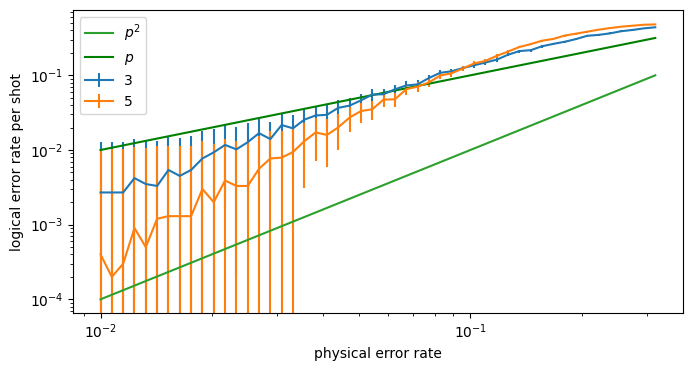

In [407]:
factory_set = [
    # rec_factory(x) for x in [3,5,7,9,11,13]
    rec_factory(3),
    rec_factory(5),
]

plot_factory_set(
    factory_set,
    num_shots=10_000,
    noise_set=np.logspace(-2,-0.5),
    filename="first_test_general_code",
    reference_lines=True,
)